In [24]:
import re
from pathlib import Path
import time

import numpy as np
import pandas as pd
import project_path  # noqa: F401
from IPython.display import Markdown, display
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
from collections import defaultdict

import experiments.setup  # noqa: F401
from experiments.utils import iterate_simulation_results, extract_dg_state_data, extract_proposal_data, extract_actor_data

In [25]:
current_dir = Path().resolve().parent.parent
out_path = current_dir.joinpath("results/simulations/")
out_path.mkdir(exist_ok=True)

token_distribution_path = current_dir.joinpath("data/stETH_token_distribution.csv")

In [26]:
pd.options.display.float_format = "{:.2f}".format
%matplotlib inline

In [27]:
from experiments.templates.withdrawal_queue_replacement import SEED, TIMESTEPS

PRESENTED_RUN = 0
simulation_name = "single_attack_sweep_first_threshold_combined"
simulation_path = out_path.joinpath(f"{simulation_name}/")

In [44]:


simulation_name = "single_attack_sweep_first_threshold_combined"
simulation_path = out_path.joinpath(simulation_name)
hashes = [p for p in simulation_path.iterdir() if p.is_dir()]

dg_state_dfs = []
proposal_dfs = []
actor_dfs = []
start = time.time()
for run_df in iterate_simulation_results(simulation_path):
    dg_state_dfs.append(extract_dg_state_data(run_df))
    proposal_dfs.append(extract_proposal_data(run_df))
    actor_dfs.append(extract_actor_data(run_df))
dg_state_df = pd.concat(dg_state_dfs, ignore_index=True)
proposal_df = pd.concat(proposal_dfs, ignore_index=True)
actors_df = pd.concat(actor_dfs, ignore_index=True)

for df in [dg_state_df, proposal_df, actors_df]:
    df['first_seal_rage_quit_support'] /= 10**16
    df['second_seal_rage_quit_support'] /= 10 **16

del dg_state_dfs, proposal_dfs, actor_dfs

print(f'Data loaded in {time.time() - start:.3f} sec')

Data loaded in 533.085 sec


In [45]:
# dg_state_df = dg_state_df[dg_state_df['second_seal_rage_quit_support'] == 15]
# proposal_df = proposal_df[proposal_df['second_seal_rage_quit_support'] == 15]
# actors_df = actors_df[actors_df['second_seal_rage_quit_support'] == 15]
for df in [dg_state_df, proposal_df, actors_df]:
    df['thresh1'] = df['first_seal_rage_quit_support']
    df['thresh2'] = df['second_seal_rage_quit_support']

In [95]:
for first_seal_rage_quit_support in sorted(proposal_df.first_seal_rage_quit_support.unique()):
    view = proposal_df[proposal_df.first_seal_rage_quit_support == first_seal_rage_quit_support]
    not_cancelled_count = view.cancelledAt.isna().sum()
    executed_count = (view.executedAt > 0).sum()
    total_count = len(view)

    veto_view = dg_state_df[(dg_state_df['dg_state_value'] == 2) & (dg_state_df['first_seal_rage_quit_support'] == first_seal_rage_quit_support)]
    time_in_veto_df = veto_view.groupby(
    ['second_seal_rage_quit_support',
     'seed']
    ).count().reset_index()
    time_in_veto_mean = time_in_veto_df.timestep.mean() * 3
    time_in_veto_std = time_in_veto_df.timestep.std() * 3

    time_to_veto_df = veto_view.groupby(
    ['first_seal_rage_quit_support',
     'second_seal_rage_quit_support',
     'seed']
).apply(lambda x: x[x['dg_state_value'] == 2].iloc[0]).reset_index(drop=True)
    time_before_veto_mean = time_to_veto_df.timestep.mean() * 3
    time_before_veto_std = time_to_veto_df.timestep.std() * 3

    display(Markdown(f"#### First Seal Rage Quit Support: **{first_seal_rage_quit_support}**"))
    display(Markdown(f"##### Runs count: **{total_count}**"))
    display(Markdown(f"##### Not cancelled proposals: **{not_cancelled_count}**  (**{not_cancelled_count / total_count:.2f}%**)"))
    display(Markdown(f"##### Executed proposals: **{executed_count}**  (**{executed_count / total_count:.2f}%**)"))
    display(Markdown(f"##### Time before veto (mean+std): **{time_before_veto_mean:.0f}+{time_before_veto_std:.0f} hours**"))
    display(Markdown(f"##### Time in veto (mean+std): **{time_in_veto_mean:.0f}+{time_in_veto_std:.0f} hours**"))
    # display(Markdown(f"##### Total Damage of Proposals: **{proposals_damage}**"))
    # display(Markdown(f"##### Average Damage per Proposal: **{average_damage}**"))

#### First Seal Rage Quit Support: **0.1**

##### Runs count: **55**

##### Not cancelled proposals: **0**  (**0.00%**)

##### Executed proposals: **0**  (**0.00%**)

##### Time before veto (mean+std): **17+1 hours**

##### Time in veto (mean+std): **129+12 hours**

#### First Seal Rage Quit Support: **0.5**

##### Runs count: **55**

##### Not cancelled proposals: **0**  (**0.00%**)

##### Executed proposals: **0**  (**0.00%**)

##### Time before veto (mean+std): **30+16 hours**

##### Time in veto (mean+std): **124+22 hours**

#### First Seal Rage Quit Support: **1.0**

##### Runs count: **55**

##### Not cancelled proposals: **0**  (**0.00%**)

##### Executed proposals: **0**  (**0.00%**)

##### Time before veto (mean+std): **45+21 hours**

##### Time in veto (mean+std): **119+26 hours**

#### First Seal Rage Quit Support: **3.0**

##### Runs count: **55**

##### Not cancelled proposals: **0**  (**0.00%**)

##### Executed proposals: **0**  (**0.00%**)

##### Time before veto (mean+std): **75+7 hours**

##### Time in veto (mean+std): **119+7 hours**

#### First Seal Rage Quit Support: **5.0**

##### Runs count: **54**

##### Not cancelled proposals: **5**  (**0.09%**)

##### Executed proposals: **5**  (**0.09%**)

##### Time before veto (mean+std): **104+46 hours**

##### Time in veto (mean+std): **100+23 hours**

In [131]:
sns.set_context('notebook')

Text(0.5, 1.0, 'Time before Veto Signalling boxplot')

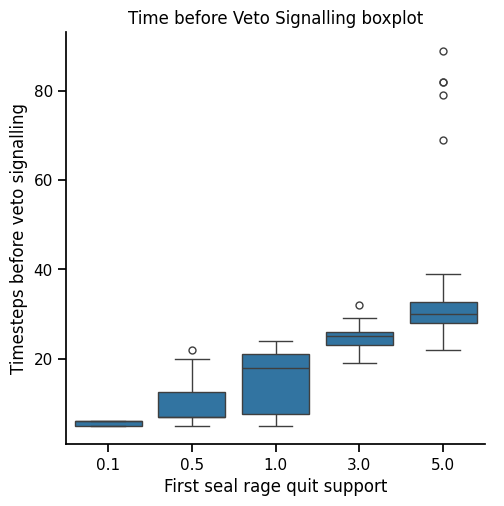

In [132]:
time_to_veto_df = dg_state_df.groupby(
    ['first_seal_rage_quit_support',
     'second_seal_rage_quit_support',
     'seed']
).apply(lambda x: x[x['dg_state_value'] == 2].iloc[0]).reset_index(drop=True)

sns.catplot(time_to_veto_df, x='thresh1', y='timestep', kind='box')
plt.gca().set_ylabel('Timesteps before veto signalling')
plt.gca().set_xlabel('First seal rage quit support')
plt.title('Time before Veto Signalling boxplot')

Text(0.5, 1.0, 'Time inside Veto Signalling stripplot')

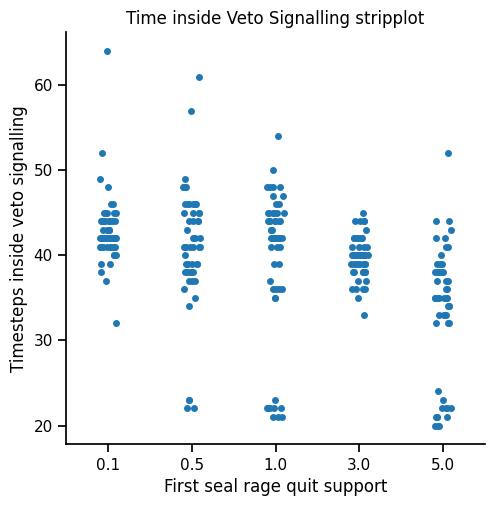

In [133]:
time_in_veto_df = dg_state_df[dg_state_df['dg_state_value'] == 2].groupby(
    ['first_seal_rage_quit_support',
     'second_seal_rage_quit_support',
     'seed']
).count().reset_index()

sns.catplot(time_in_veto_df, x='first_seal_rage_quit_support', y='timestep', kind='strip')
plt.gca().set_ylabel('Timesteps inside veto signalling')
plt.gca().set_xlabel('First seal rage quit support')
plt.title('Time inside Veto Signalling stripplot')

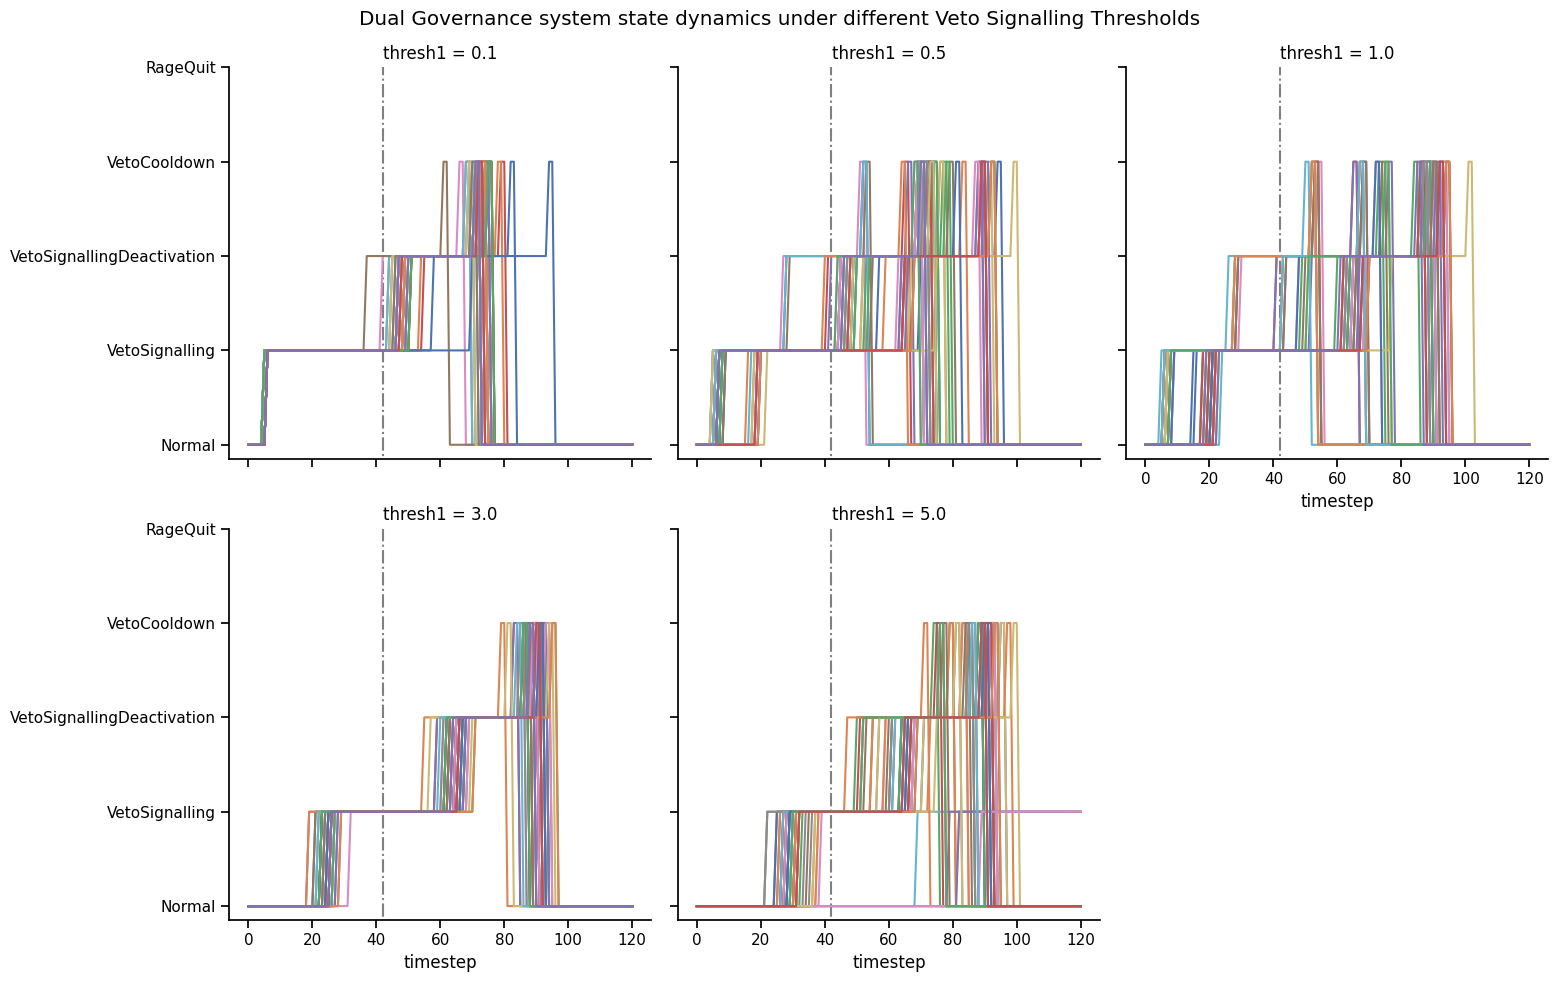

In [135]:
g = sns.relplot(dg_state_df, x='timestep', y='dg_state_value', col='thresh1',
            kind='line', hue='seed', palette='deep', col_wrap=3
           )

if g._legend:
    g._legend.remove()

g.axes[0].set_ylabel('')
g.axes[3].set_ylabel('')
state_names = {1: "Normal", 2: "VetoSignalling", 3: "VetoSignallingDeactivation", 4: "VetoCooldown", 5: "RageQuit"}
plt.gca().set_yticks(list(state_names.keys()), labels=list(state_names.values()));

for thresh_val in g.col_names:
    ax = g.axes_dict[thresh_val]

    ylim = ax.get_ylim()
    execution_timestep = 2 + 5 * 24 / 3
    execution_time_line = ax.plot([execution_timestep, execution_timestep], [0, ylim[1]], color='gray', linestyle='-.', zorder=0, label='Time when proposal will be executed')
    ax.set_ylim(ylim)

    # ax.legend([execution_time_line[0]], ['Time when proposal will be executed'])

plt.suptitle('Dual Governance system state dynamics under different Veto Signalling Thresholds')
plt.tight_layout()

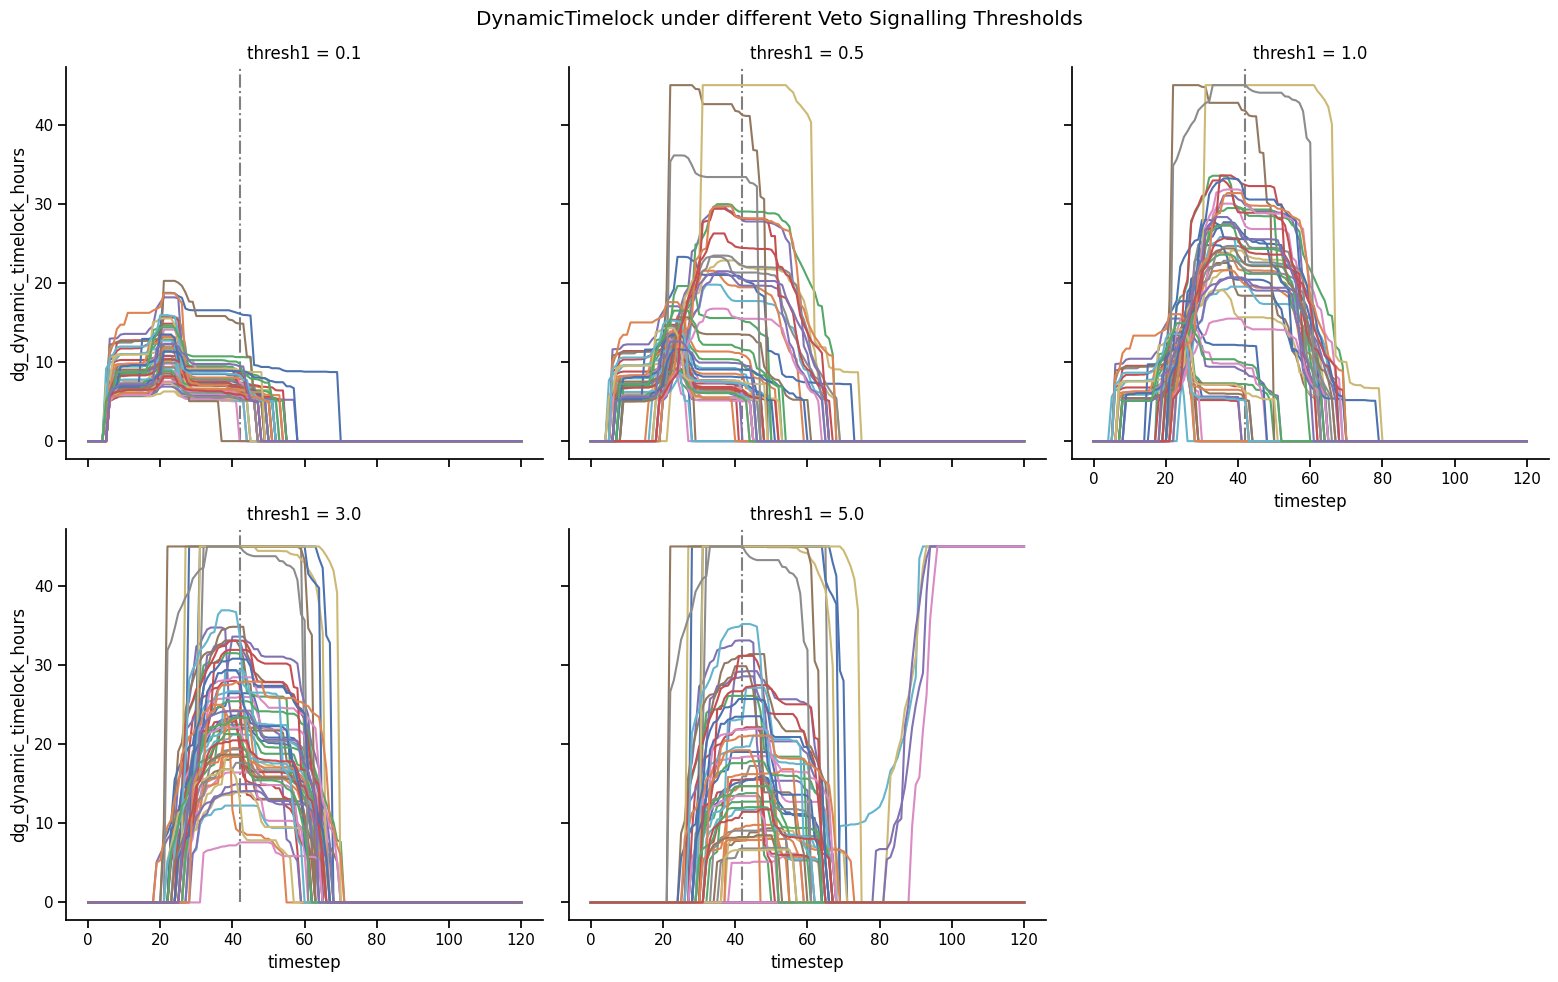

In [155]:
g = sns.relplot(dg_state_df, x='timestep', y='dg_dynamic_timelock_hours', col='thresh1',
            kind='line', hue='seed', palette='deep', col_wrap=3
           )

if g._legend:
    g._legend.remove()

# g.axes[0].set_ylabel('')
# g.axes[3].set_ylabel('')
# state_names = {1: "Normal", 2: "VetoSignalling", 3: "VetoSignallingDeactivation", 4: "VetoCooldown", 5: "RageQuit"}
# plt.gca().set_yticks(list(state_names.keys()), labels=list(state_names.values()));

for thresh_val in g.col_names:
    ax = g.axes_dict[thresh_val]

    ylim = ax.get_ylim()
    execution_timestep = 2 + 5 * 24 / 3
    execution_time_line = ax.plot([execution_timestep, execution_timestep], [0, ylim[1]], color='gray', linestyle='-.', zorder=0, label='Time when proposal will be executed')
    ax.set_ylim(ylim)

    # ax.legend([execution_time_line[0]], ['Time when proposal will be executed'])

plt.suptitle('DynamicTimelock under different Veto Signalling Thresholds')
plt.tight_layout()

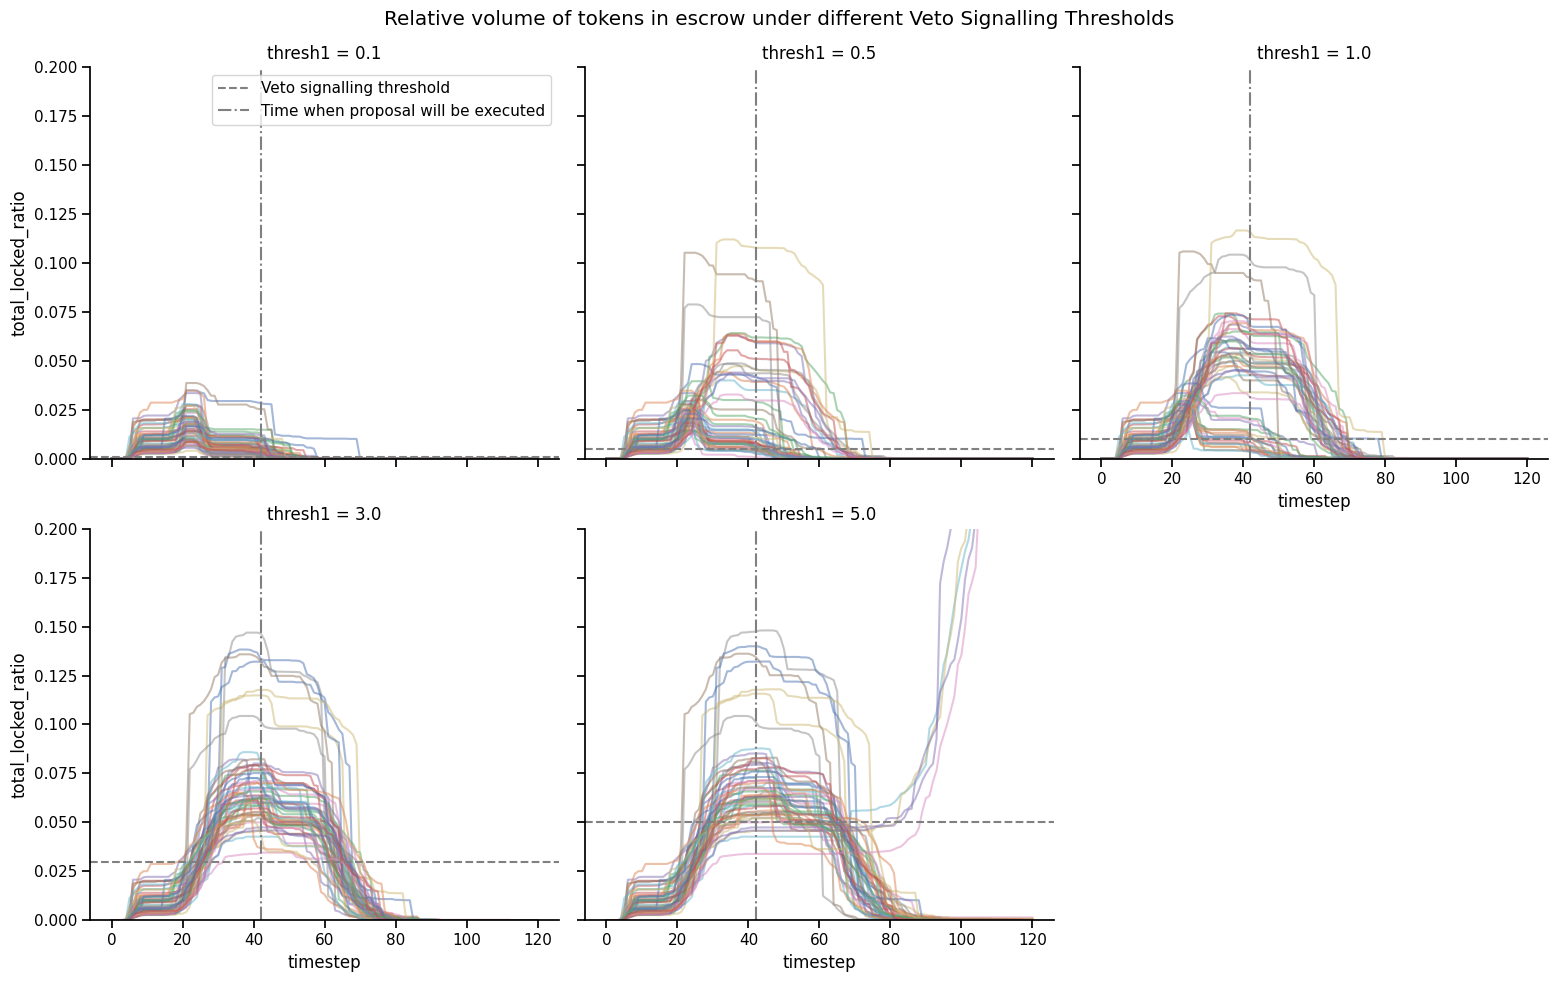

In [140]:
actors_df['sseed'] = 's' + actors_df['seed'].map(str)
a = sns.relplot(actors_df, x='timestep', y='total_locked_ratio', col='thresh1',
            kind='line', hue='seed', palette='deep', col_wrap=3, alpha=0.5
           )
if a._legend:
    a._legend.remove()
for thresh_val in a.col_names:
    ax = a.axes_dict[thresh_val]
    xlim = ax.get_xlim()
    thresh_line = ax.plot(xlim, np.array([thresh_val, thresh_val]) / 100, linestyle='--', color='gray', label='Veto signalling threshold')
    ax.set_xlim(xlim)

    # ylim = ax.get_ylim()
    ylim = [0, 0.2]
    execution_timestep = 2 + 5 * 24 / 3
    execution_time_line = ax.plot([execution_timestep, execution_timestep], [0, ylim[1]], color='gray', linestyle='-.', label='Time when proposal will be executed')
    ax.set_ylim(ylim)

    if thresh_val == 0.1:
        ax.legend([thresh_line[0], execution_time_line[0]], ['Veto signalling threshold', 'Time when proposal will be executed'])

plt.suptitle('Relative volume of tokens in escrow under different Veto Signalling Thresholds')
plt.tight_layout()

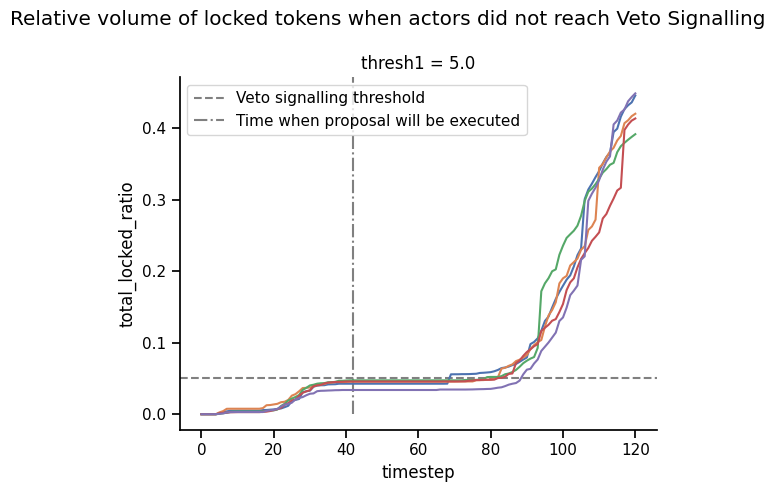

In [144]:
not_cancelled_proposals = proposal_df[proposal_df.cancelledAt.isna()]
actors_not_cancelled = actors_df[actors_df.seed.isin(not_cancelled_proposals.seed) & actors_df.first_seal_rage_quit_support.isin(not_cancelled_proposals.first_seal_rage_quit_support)]

a = sns.relplot(actors_not_cancelled, x='timestep', y='total_locked_ratio', col='thresh1',
            kind='line', hue='seed', palette='deep'
           )
if a._legend:
    a._legend.remove()
for thresh_val in a.col_names:
    ax = a.axes_dict[thresh_val]
    xlim = ax.get_xlim()
    thresh_line = ax.plot(xlim, np.array([thresh_val, thresh_val]) / 100, linestyle='--', color='gray', zorder=0, label='Veto signalling threshold')
    ax.set_xlim(xlim)

    ylim = ax.get_ylim()
    execution_timestep = 2 + 5 * 24 / 3
    execution_time_line = ax.plot([execution_timestep, execution_timestep], [0, ylim[1]], color='gray', linestyle='-.', zorder=0, label='Time when proposal will be executed')
    ax.set_ylim(ylim)

    ax.legend([thresh_line[0], execution_time_line[0]], ['Veto signalling threshold', 'Time when proposal will be executed'])

plt.suptitle('Relative volume of locked tokens when actors did not reach Veto Signalling')
plt.tight_layout()

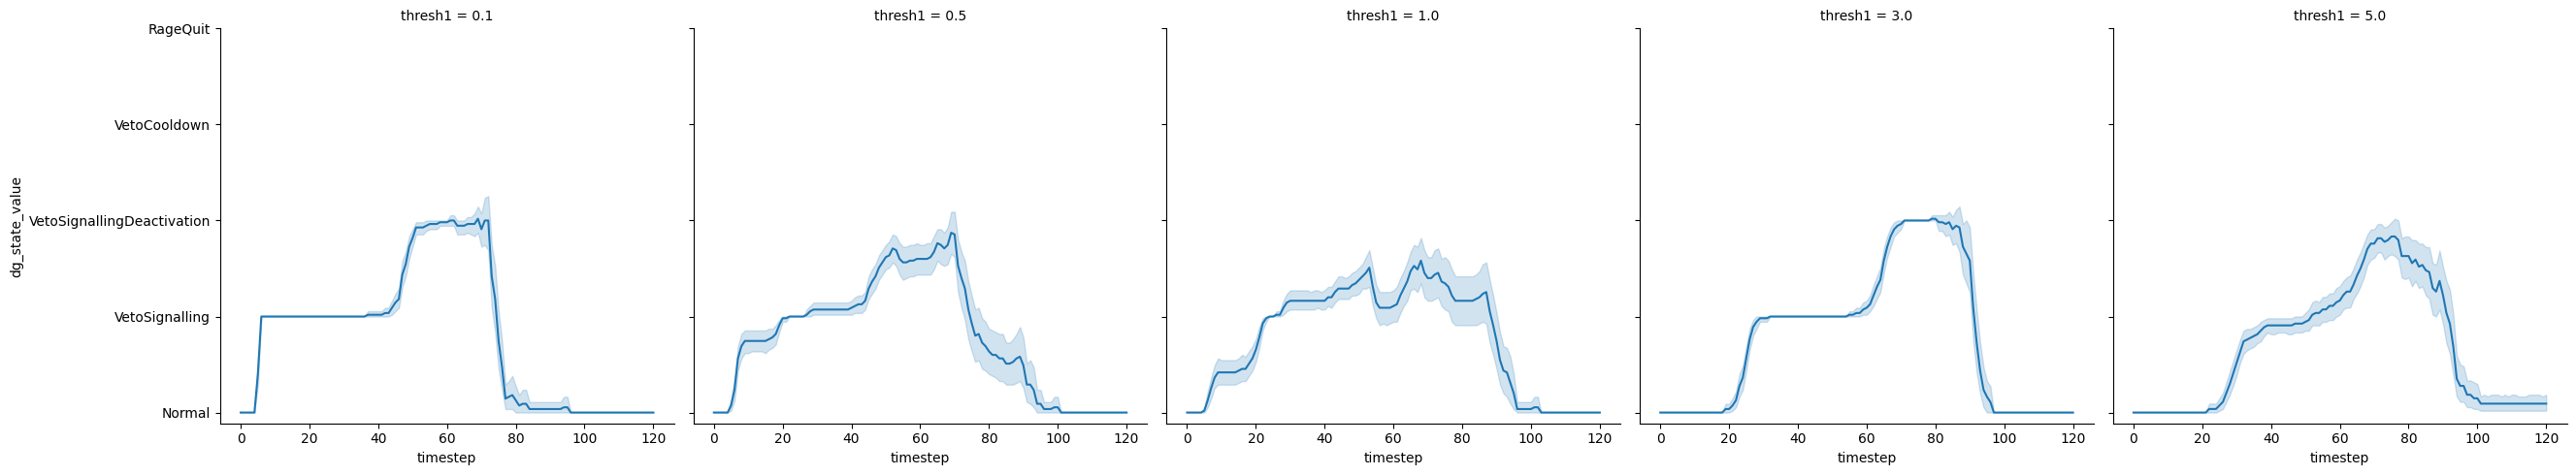

In [46]:
sns.relplot(dg_state_df, x='timestep', y='dg_state_value', col='thresh1',
            kind='line'
           )

state_names = {1: "Normal", 2: "VetoSignalling", 3: "VetoSignallingDeactivation", 4: "VetoCooldown", 5: "RageQuit"}
plt.gca().set_yticks(list(state_names.keys()), labels=list(state_names.values()))

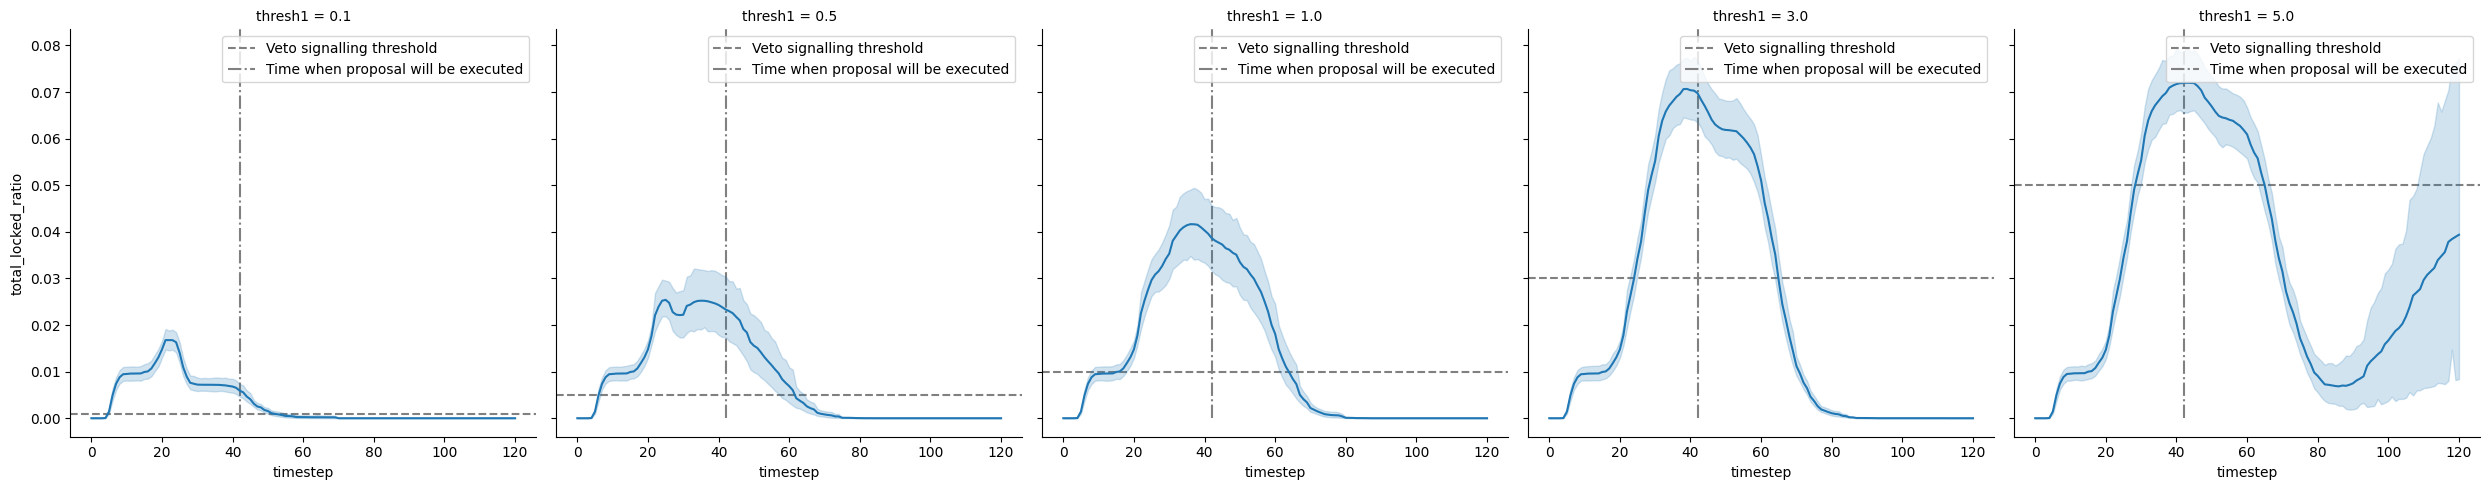

In [78]:
a = sns.relplot(actors_df, x='timestep', y='total_locked_ratio', col='thresh1',
            kind='line'
           )
if a._legend:
    a._legend.remove()
for thresh_val in a.col_names:
    ax = a.axes_dict[thresh_val]
    xlim = ax.get_xlim()
    thresh_line = ax.plot(xlim, np.array([thresh_val, thresh_val]) / 100, linestyle='--', color='gray', zorder=0, label='Veto signalling threshold')
    ax.set_xlim(xlim)

    ylim = ax.get_ylim()
    execution_timestep = 2 + 5 * 24 / 3
    execution_time_line = ax.plot([execution_timestep, execution_timestep], [0, ylim[1]], color='gray', linestyle='-.', zorder=0, label='Time when proposal will be executed')
    ax.set_ylim(ylim)

    ax.legend([thresh_line[0], execution_time_line[0]], ['Veto signalling threshold', 'Time when proposal will be executed'])

Text(0.5, 28.999999999999986, 'First seal rage quit support')

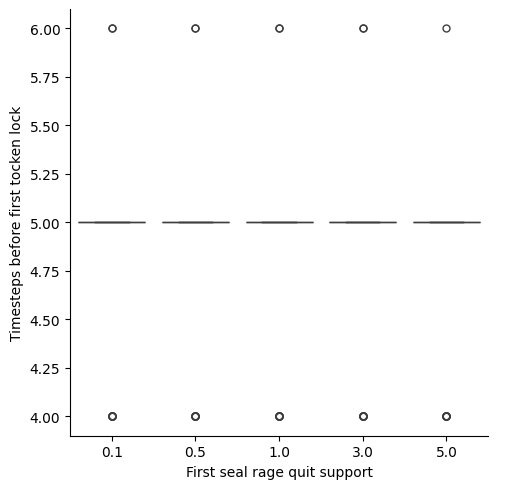

In [50]:
time_to_react_df = actors_df.groupby(
    ['first_seal_rage_quit_support',
     'second_seal_rage_quit_support',
     'seed']
).apply(lambda x: x[x['actor_locked'] > 0].iloc[0]).reset_index(drop=True)

sns.catplot(time, x='thresh1', y='timestep', kind='box')
plt.gca().set_ylabel('Timesteps before first tocken lock')
plt.gca().set_xlabel('First seal rage quit support')

Text(0.5, 29.140624999999986, 'First seal rage quit support')

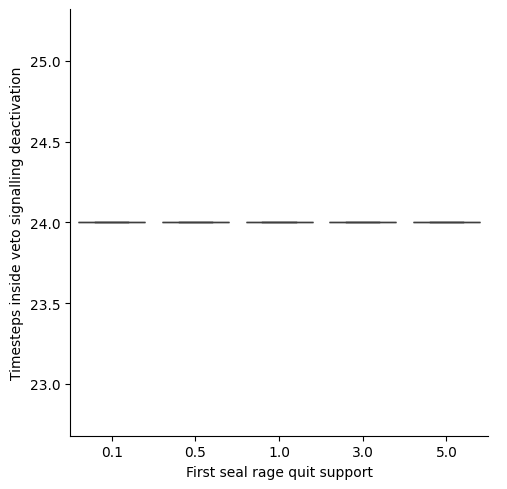

In [56]:
time_in_veto_df = dg_state_df[dg_state_df['dg_state_value'] == 3].groupby(
    ['first_seal_rage_quit_support',
     'second_seal_rage_quit_support',
     'seed']
).count().reset_index()

sns.catplot(time_in_veto_df, x='first_seal_rage_quit_support', y='timestep', kind='box')
plt.gca().set_ylabel('Timesteps inside veto signalling deactivation')
plt.gca().set_xlabel('First seal rage quit support')

Text(0.5, 29.140624999999986, 'First seal rage quit support')

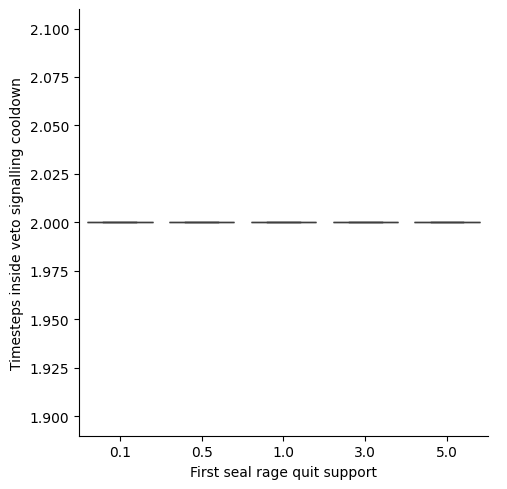

In [57]:
time_in_veto_df = dg_state_df[dg_state_df['dg_state_value'] == 4].groupby(
    ['first_seal_rage_quit_support',
     'second_seal_rage_quit_support',
     'seed']
).count().reset_index()

sns.catplot(time_in_veto_df, x='first_seal_rage_quit_support', y='timestep', kind='box')
plt.gca().set_ylabel('Timesteps inside veto signalling cooldown')
plt.gca().set_xlabel('First seal rage quit support')